In [75]:
#pip install space_bandits

In [76]:
import numpy as np
import space_bandits
import matplotlib.pyplot as plt

# Here we implement the wheel bandit from the paper (section 5.4)

First, produce uniform samples from the unit circle.

Uniform samples in the unit circle


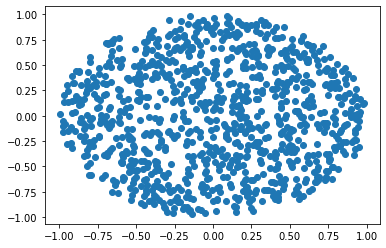

In [77]:
def get_context():
    # sample uniformly from the unit circle
    length = np.sqrt(np.random.uniform(0, 1)) # the square root guarantees uniform sampling
    angle = np.pi * np.random.uniform(0, 2)

    return np.array([length,angle])


def polar_to_cartesian(length_angle):
    x = length_angle[0] * np.cos(length_angle[1])
    y = length_angle[0] * np.sin(length_angle[1])
    return np.array([x,y]) 

# check consistency
sample_num = 1000
samples = np.zeros((1000,2))
for i in range(sample_num):
    samples[i,:] = polar_to_cartesian(get_context())

print('Uniform samples in the unit circle')
plt.scatter(samples[:,0],samples[:,1])
plt.show()


Now we implement the 5 different reward functions for the 5 arms.

In [78]:
# roles of the variables are described in section 5.4 of the paper.
delta = 0.5
mu_1 = 1.2
mu_2 = 1
mu_3 = 50
sigma = 0.01

def reward_a1(x_polar):
    return np.random.normal(mu_1,sigma)

def reward_a2(x_polar):
    if x_polar[0] < delta:
        return np.random.normal(mu_2,sigma)
    elif x_polar[1] < np.pi/2:
        return np.random.normal(mu_3,sigma)
    else:
        return np.random.normal(mu_2,sigma)

def reward_a3(x_polar):
    if x_polar[0] < delta:
        return np.random.normal(mu_2,sigma)
    elif (x_polar[1] > np.pi/2) and (x_polar[1] < np.pi):
        return np.random.normal(mu_3,sigma)
    else:
        return np.random.normal(mu_2,sigma)

def reward_a4(x_polar):
    if x_polar[0] < delta:
        return np.random.normal(mu_2,sigma)
    elif (x_polar[1] > np.pi) and (x_polar[1] < 3*np.pi/2):
        return np.random.normal(mu_3,sigma)
    else:
        return np.random.normal(mu_2,sigma)

def reward_a5(x_polar):
    if x_polar[0] < delta:
        return np.random.normal(mu_2,sigma)
    elif x_polar[1] > 3*np.pi/2:
        return np.random.normal(mu_3,sigma)
    else:
        return np.random.normal(mu_2,sigma)


funcs = {0:reward_a1,1:reward_a2,2:reward_a3,3:reward_a4,4:reward_a5}
def get_reward(context,action):
    return funcs[action](context)

def get_rewards(context):
    return np.array([funcs[0](context),funcs[1](context),funcs[2](context),funcs[3](context),funcs[4](context)])

def best_action(context):
    if context[0] < delta:
        return 0
    elif context[1] < np.pi/2:
        return 1
    elif (context[1] > np.pi/2) and (context[1] < np.pi):
        return 2
    elif (context[1] > np.pi) and (context[1] < 3*np.pi/2):
        return 3
    elif context[1] > 3*np.pi/2:
        return 4

# Try to train a linear model

In [80]:
from space_bandits import LinearBandits

num_actions = 5 
num_features = 2 

model = LinearBandits(num_actions, num_features)

In [81]:
for i in range(1000):
    context = get_context()
    action = np.random.randint(0, num_actions)
    reward = get_reward(context,action)
    model.update(context, action, reward)

In [82]:
new_context = get_context()
print('new example context vector: \n', new_context)

print('\nmodel suggested action: ')
print(model.action(new_context))

print('\nactual best action: ')
print(best_action(new_context))

new example context vector: 
 [0.54702271 1.47302791]

model suggested action: 
1

actual best action: 
1


# Try to train a Neural Linear model

In [83]:
from space_bandits import NeuralBandits

num_actions = 5 
num_features = 2 

NNmodel = NeuralBandits(num_actions, num_features)

In [84]:
for i in range(1000):
    context = get_context()
    action = np.random.randint(0, num_actions)
    reward = get_reward(context,action)
    NNmodel.update(context, action, reward)

Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...


In [85]:
new_context = get_context()
print('new example context vector: \n', new_context)

print('\nvalues of each action expected by the model: ')
print(NNmodel.expected_values(new_context))

print('\nactual values of each action: ')
print(get_rewards(new_context))

new example context vector: 
 [0.91699048 4.57894775]

values of each action expected by the model: 
[   1.98239352   99.56849954   -7.18590851 -210.79386151   77.73047576]

actual values of each action: 
[ 1.19354613  1.01858337  0.99137753 49.98544807  0.99344564]


In [86]:
new_context = get_context()
print('new example context vector: \n', new_context)

print('\nmodel suggested action: ')
print(NNmodel.action(new_context))

print('\nactual best action: ')
print(best_action(new_context))

new example context vector: 
 [0.73810343 0.34419804]

model suggested action: 
1

actual best action: 
1


# Online Training

In [87]:
def iterate_model(model, steps, records=None, plot_frequency=250, avg_length=150):
    """Goes through online learning simulation with model."""
    #these will track values for plotting
    if records is None:
        records = dict()
        records['timesteps'] = []
        records['c_reward'] = []
        records['cumulative_reward'] = 0
        records['m_reward'] = []
        records['maximum_reward'] = 0
        records['regret_record'] = []
        records['avg_regret'] = []
        start = 0
    else:
        start = records['timesteps'][-1]
    for i in range(start, start+steps):
        records['timesteps'].append(i)
        #generate context
        context = get_context()
        #get the rewards for each of the different actions
        reward_vec = get_rewards(context)
        #get optimal action
        best_choice = best_action(context)
        #get reward for 'best' choice
        mx = reward_vec[best_choice]
        records['maximum_reward'] += mx
        records['m_reward'].append(records['maximum_reward'])
        action = model.action(context)
        #get reward for the action chosen by model
        reward = reward_vec[action]
        #regret is the opportunity cost of not choosing the optimal action
        regret = mx - reward
        records['regret_record'].append(regret)
        records['cumulative_reward'] += reward
        records['c_reward'].append(records['cumulative_reward'])
        model.update(context, action, reward)
        #plot occasionally
        if i <= avg_length:
            if i < avg_length:
                moving_avg=0
            else:
                moving_avg = np.array(records['regret_record']).mean()
            if i == avg_length:
                records['avg_regret'] = [moving_avg] * avg_length
        else:
            moving_avg = sum(records['regret_record'][-avg_length:])/avg_length
        records['avg_regret'].append(moving_avg)
        if i % plot_frequency == 0 and i > 0:
            c_rewardplt = np.array(records['c_reward'])/max(records['m_reward'])
            m_rewardplt = np.array(records['m_reward'])/max(records['m_reward'])
            regretplt = np.array(records['avg_regret'])/max(records['avg_regret'])
            plt.plot(records['timesteps'], c_rewardplt, label='cumulative reward')
            plt.plot(records['timesteps'], m_rewardplt, label='maximum reward')
            plt.plot(records['timesteps'], regretplt, color='red', label='mean regret')
            plt.title('Normalized Reward & Regret')
            plt.legend()
            plt.show()
    return records
            

### Monitor Regret with a linear model

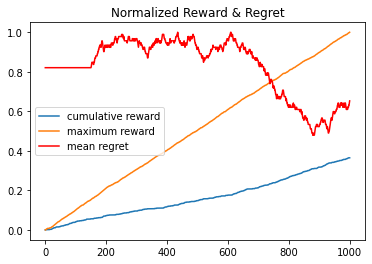

In [88]:
linear_model = LinearBandits(num_actions, num_features)
steps = 1001
records = iterate_model(linear_model, steps, plot_frequency=steps-1)

### Monitor Regret with a Neural Linear model

Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...


/usr/local/lib/python3.6/dist-packages/space_bandits/neural_linear.py:281: RuntimeWarning: covariance is not positive-semidefinite.
  multivariates = [np.random.multivariate_normal(mus[j], covs[j]) for j in range(n_rows)]


Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...


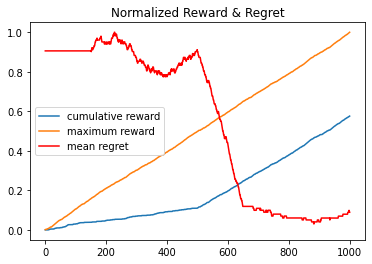

In [89]:
neural_model = NeuralBandits(num_actions, num_features)
steps = 1001
records = iterate_model(neural_model, steps, plot_frequency=steps-1)